# Predicting Home Value
#### Our goal is to understand what creates value in a house as if we were real estate developers.

In [121]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import time
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, MissingIndicator
# from fancyimpute import KNN - need other packages to run this!

from IPython.display import display
pd.options.display.max_columns = None

warnings.filterwarnings('ignore')

## Load in data and take a peek

In [2]:
# import data
data = pd.read_csv('Melbourne_housing_FULL.csv')
print(data.head())

       Suburb             Address  Rooms Type      Price Method SellerG  \
0  Abbotsford       68 Studley St      2    h        NaN     SS  Jellis   
1  Abbotsford        85 Turner St      2    h  1480000.0      S  Biggin   
2  Abbotsford     25 Bloomburg St      2    h  1035000.0      S  Biggin   
3  Abbotsford  18/659 Victoria St      3    u        NaN     VB  Rounds   
4  Abbotsford        5 Charles St      3    h  1465000.0     SP  Biggin   

        Date  Distance  Postcode  Bedroom2  Bathroom  Car  Landsize  \
0  3/09/2016       2.5    3067.0       2.0       1.0  1.0     126.0   
1  3/12/2016       2.5    3067.0       2.0       1.0  1.0     202.0   
2  4/02/2016       2.5    3067.0       2.0       1.0  0.0     156.0   
3  4/02/2016       2.5    3067.0       3.0       2.0  1.0       0.0   
4  4/03/2017       2.5    3067.0       3.0       2.0  0.0     134.0   

   BuildingArea  YearBuilt         CouncilArea  Lattitude  Longtitude  \
0           NaN        NaN  Yarra City Council   

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

### Variable Description
**Suburb:** Suburb  
**Address:** Address  
**Rooms:** Number of rooms  
**Price:** Price in Australian dollars  
**Method:** S - property sold; SP - property sold prior; PI - property passed in; PN - sold prior not disclosed; SN - sold not disclosed; NB - no bid; VB - vendor bid; W - withdrawn prior to auction; SA - sold after auction; SS - sold after auction price not disclosed. N/A - price or highest bid not available.  
**Type:** br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.  
**SellerG:** Real Estate Agent  
**Date:** Date sold  
**Distance:** Distance from CBD in Kilometres  
**Regionname:** General Region (West, North West, North, North east ...etc)  
**Propertycount:** Number of properties that exist in the suburb.  
**Bedroom2:** Scraped # of Bedrooms (from different source)  
**Bathroom:** Number of Bathrooms  
**Car:** Number of carspots  
**Landsize:** Land Size in Metres  
**BuildingArea:** Building Size in Metres  
**YearBuilt:** Year the house was built  
**CouncilArea:** Governing council for the area  
**Lattitude:** Self explanitory  
**Longtitude:** Self explanitory  

## Handle missing data

In [4]:
# check amount of missing
print('There are {} observations and {} variables'.format(data.shape[0],data.shape[1]))
print(data.isnull().sum())

There are 34857 observations and 21 variables
Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          8217
Bathroom          8226
Car               8728
Landsize         11810
BuildingArea     21115
YearBuilt        19306
CouncilArea          3
Lattitude         7976
Longtitude        7976
Regionname           3
Propertycount        3
dtype: int64


In [5]:
display(data[data.Postcode.isnull()])
display(data[data.Regionname.isnull()])

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
29483,Fawkner Lot,1/3 Brian St,3,h,616000.0,SP,Brad,6/01/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
18523,Footscray,2/16 Stafford St,2,u,710000.0,S,Jas,15/07/2017,5.1,3011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26888,Camberwell,2/3 Kingsley St,2,h,825000.0,VB,Jellis,11/11/2017,7.7,3124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29483,Fawkner Lot,1/3 Brian St,3,h,616000.0,SP,Brad,6/01/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Use distance, postcode, council area, regionname, and propertycount from Fawkner to fill Fawkner Lot
needed_vals = ['Distance', 'Postcode', 'CouncilArea', 'Regionname', 'Propertycount']
fawkner = []
for val in needed_vals:
    fawkner.append(data.loc[data['Suburb']=='Fawkner', val].value_counts().index.tolist()[0])
    
fawkzip = dict(zip(needed_vals,fawkner))

# get index for Fawkner Lot
fl = (data[data['Suburb']=='Fawkner Lot']).index

data.iloc[fl] = data.iloc[fl].fillna(fawkzip)
display(data.iloc[fl])

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
29483,Fawkner Lot,1/3 Brian St,3,h,616000.0,SP,Brad,6/01/2018,12.4,3060.0,NaN,NaN,NaN,NaN,NaN,NaN,Hume City Council,NaN,NaN,Northern Metropolitan,5070.0


In [7]:
# get indexes
f_idx = data.loc[(data['Suburb']=='Footscray')&(data['Regionname'].isnull())].index[0]
c_idx = data.loc[(data['Suburb']=='Camberwell')&(data['Regionname'].isnull())].index[0]

In [8]:
# Fill rest of missing object variables

ffillkeys = []
cfillkeys = []
needvals = ['CouncilArea', 'Regionname', 'Propertycount']
for i in needvals:
    ffillkeys.append(data.loc[data['Suburb']=='Footscray', i].value_counts().index.tolist()[0])
    cfillkeys.append(data.loc[data['Suburb']=='Camberwell', i].value_counts().index.tolist()[0])

fzip = dict(zip(needvals,ffillkeys))
czip = dict(zip(needvals,cfillkeys))

data.iloc[f_idx] = data.iloc[f_idx].fillna(fzip)
data.iloc[c_idx] = data.iloc[c_idx].fillna(czip)


print(data.iloc[f_idx])
print(data.iloc[c_idx])

print(data.isnull().sum())

Suburb                          Footscray
Address                  2/16 Stafford St
Rooms                                   2
Type                                    u
Price                              710000
Method                                  S
SellerG                               Jas
Date                           15/07/2017
Distance                              5.1
Postcode                             3011
Bedroom2                              NaN
Bathroom                              NaN
Car                                   NaN
Landsize                              NaN
BuildingArea                          NaN
YearBuilt                             NaN
CouncilArea      Maribyrnong City Council
Lattitude                             NaN
Longtitude                            NaN
Regionname           Western Metropolitan
Propertycount                        7570
Name: 18523, dtype: object
Suburb                        Camberwell
Address                  2/3 Kingsley St
Rooms    

We will use the built in imputer function in sklearn to impute the rest of the missing values.  SimpleImputer gives the option to set the strategy for imputing values to mean, median, most_frequent (can be used on either numeric or categorical / equivalent to mode), or a constant value.  MissingIndicator will fill missing values with a binary indicator.

We will create new columns to keep track of the imputed data so that if there is some trend or reason for the missing values the model will have that information available.

In [9]:
# get medians for all the numeric columns to make sure they're okay
data.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34857.000000,34857.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34857.000000
mean,3.031012,1.050173e+06,11.184964,3116.061250,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.855065
std,0.969933,6.414671e+05,6.788798,109.022752,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4427.925923
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


There are definitely some interesting things to notice in the data.  There is likely a typo in the Year Built column because the max value is 2106, also the min value is 1196 and according to wikipedia, there may have been hunter and gatherer tribes that inhabited the area well before the founding of the city but the city of Melbourne was founded in 1835, so that value is significantly off.  The other outliers that jump out are the max values for Landsize and Building Area.  They seem extreme compared to the mean or even third quartile.  

Upon further research on the landsize and building area outliers the landsize outlier will be replaced with the correct values, and the building area is correct.

In [10]:
minyr = data[data.YearBuilt==1196].index[0]
maxyr = data[data.YearBuilt==2106].index[0]

In [11]:
# Replace 1196 with 1996 and 2106 with 2016
data.iloc[minyr, 15] = 1996
data.iloc[maxyr, 15] = 2016

In [12]:
maxland = data[data.Landsize==data.Landsize.max()].index[0]

In [13]:
# according to an online search of this location landsize = 107m2, buildingsize= 207m2, and year built = 1890
data.iloc[maxland, 13:16] = [107, 207, 1890]
display(data.iloc[maxland])

Suburb                         Fitzroy
Address                    389 Gore St
Rooms                                3
Type                                 h
Price                          2.7e+06
Method                              VB
SellerG                            Kay
Date                        12/08/2017
Distance                           2.1
Postcode                          3065
Bedroom2                             3
Bathroom                             3
Car                                  1
Landsize                           107
BuildingArea                       207
YearBuilt                         1890
CouncilArea         Yarra City Council
Lattitude                     -37.7975
Longtitude                     144.983
Regionname       Northern Metropolitan
Propertycount                     5825
Name: 18036, dtype: object

In [14]:
# Initialize the imputer
simputer = SimpleImputer(strategy='median')

# Grab only numeric data for imputer using median to work
nums = data.select_dtypes(exclude='object')
nums.drop('Price', 1 ,inplace=True)
obj = data.select_dtypes(include='object')

# We want to track the changes we are adding to the data set.
# Get the columns that have missing values
missing_cols = (col for col in nums.columns if nums[col].isnull().any())

# Create new columns to track changes with binary outcome
for col in missing_cols:
    nums['Tracker'+col] = nums[col].isnull()

# Impute the rest of the missing values using median to get integer values
numfeatures = simputer.fit_transform(nums)
colnames = nums.columns
numfeatures = pd.DataFrame(numfeatures, columns=colnames)

# Recombine into one dataset
newdata = pd.concat([obj, numfeatures],1)
print(newdata.head())
print(newdata.isnull().sum())
print(newdata.shape)

       Suburb             Address Type Method SellerG       Date  \
0  Abbotsford       68 Studley St    h     SS  Jellis  3/09/2016   
1  Abbotsford        85 Turner St    h      S  Biggin  3/12/2016   
2  Abbotsford     25 Bloomburg St    h      S  Biggin  4/02/2016   
3  Abbotsford  18/659 Victoria St    u     VB  Rounds  4/02/2016   
4  Abbotsford        5 Charles St    h     SP  Biggin  4/03/2017   

          CouncilArea             Regionname  Rooms  Distance  Postcode  \
0  Yarra City Council  Northern Metropolitan    2.0       2.5    3067.0   
1  Yarra City Council  Northern Metropolitan    2.0       2.5    3067.0   
2  Yarra City Council  Northern Metropolitan    2.0       2.5    3067.0   
3  Yarra City Council  Northern Metropolitan    3.0       2.5    3067.0   
4  Yarra City Council  Northern Metropolitan    3.0       2.5    3067.0   

   Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  Lattitude  \
0       2.0       1.0  1.0     126.0         136.0     1970.0   

In [15]:
# Handle the date variable
newdata['Date'] = pd.to_datetime(newdata.Date, dayfirst=True)
newdata['Year'] = newdata.Date.dt.year
newdata['Month'] = newdata.Date.dt.month
newdata['Day'] = newdata.Date.dt.day
newdata['Weekday'] = newdata.Date.dt.dayofweek

newdata.drop('Date', 1, inplace=True)

Let's now address the missing data in the dependent variable.  We will try 2 methods: 1) Drop the missings from the entire dataset and 2) Impute the median value for each Suburb to fill the missings.

In [16]:
#display(data[data.Price.isnull()])

In [17]:
# create full data set that drops all missing values from price
drop_df = pd.concat([newdata,data.Price],1)
drop_df.dropna(inplace=True)
print(drop_df.shape)
print(drop_df.isnull().sum().sum())

(27247, 32)
0


In [18]:
# Get median Price for each suburb to fill missings
fullmed = data.Price.median()
meds = data.groupby('Suburb')['Price'].median()
subs = data.Suburb.unique()

imputed_df = newdata.copy()
imputed_df['Price'] = data.Price

for sub in subs:
    imputed_df.loc[(imputed_df['Price'].isnull()) & (imputed_df['Suburb']==sub), 'Price'] = meds[sub]
    
print(imputed_df.shape)
#display(imputed_df[imputed_df.Price.isnull()])

# get the count for the remaining suburbs
print(imputed_df.Suburb[imputed_df.Price.isnull()].value_counts())

# for the last 6 missing values, since there suburbs only appear once we will use the median price for the dataset.
remaining_subs = imputed_df.Suburb[imputed_df.Price.isnull()].value_counts().index.tolist()

for sub in remaining_subs:
    imputed_df.loc[(imputed_df['Price'].isnull()) & (imputed_df['Suburb']==sub), 'Price'] = fullmed

print(imputed_df.isnull().sum().sum())

(34857, 32)
Belgrave         1
Menzies Creek    1
Guys Hill        1
Olinda           1
Hopetoun Park    1
Avonsleigh       1
Name: Suburb, dtype: int64
0


Now we have two datasets, one that we dropped the missings for price from and one that we imputed the medians for each suburb.

In [19]:
# change the object variables to categories so they follow a logical order for plotting
objs_drop = drop_df.select_dtypes(include='object').columns

imputed_obj = imputed_df.select_dtypes(include='object').columns

for ob in objs_drop:
    drop_df[ob] = drop_df[ob].astype('category')
    
for ob in imputed_obj:
    print(ob)
    imputed_df[ob] = imputed_df[ob].astype('category')
    
# add the postal code as categorical variable
drop_df['Postcode'] = drop_df['Postcode'].astype('category')
imputed_df['Postcode'] = imputed_df['Postcode'].astype('category')
    
#print(drop_df.info())
print(imputed_df.info())

Suburb
Address
Type
Method
SellerG
CouncilArea
Regionname
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 32 columns):
Suburb                 34857 non-null category
Address                34857 non-null category
Type                   34857 non-null category
Method                 34857 non-null category
SellerG                34857 non-null category
CouncilArea            34857 non-null category
Regionname             34857 non-null category
Rooms                  34857 non-null float64
Distance               34857 non-null float64
Postcode               34857 non-null category
Bedroom2               34857 non-null float64
Bathroom               34857 non-null float64
Car                    34857 non-null float64
Landsize               34857 non-null float64
BuildingArea           34857 non-null float64
YearBuilt              34857 non-null float64
Lattitude              34857 non-null float64
Longtitude             34857 non-null float

## Look at data

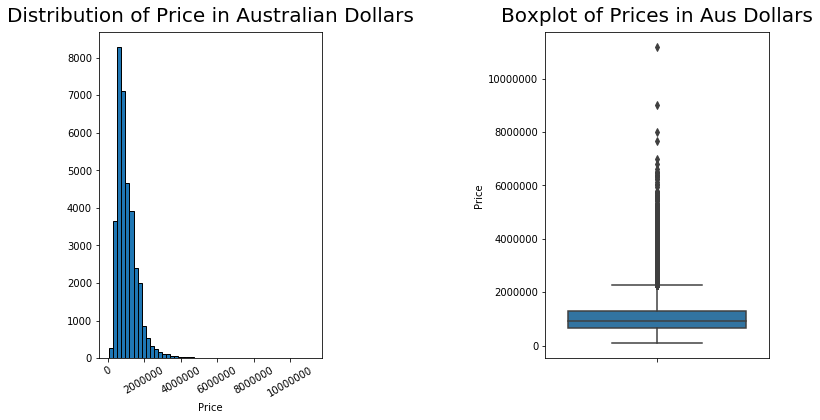

count    2.724700e+04
mean     1.050173e+06
std      6.414671e+05
min      8.500000e+04
25%      6.350000e+05
50%      8.700000e+05
75%      1.295000e+06
max      1.120000e+07
Name: Price, dtype: float64


In [20]:
# distribution of dependent variable
fig =plt.figure(1,figsize=(12,6))
fig.subplots_adjust(wspace = 1)
ax = fig.add_subplot(1,2,1)
plt.hist(imputed_df.Price, edgecolor='k', bins=50)
plt.title('Distribution of Price in Australian Dollars', fontsize=20, pad=10)
plt.xlabel('Price')
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=30)

ax1 = fig.add_subplot(1,2,2)
sns.boxplot(y=imputed_df.Price)
plt.title('Boxplot of Prices in Aus Dollars', fontsize =20, pad=10)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

print(data.Price.describe())

The Price looks normally distributed with a right skewness.  It also appears that there are some outliers here in the price column with the max price being $11,200,000.

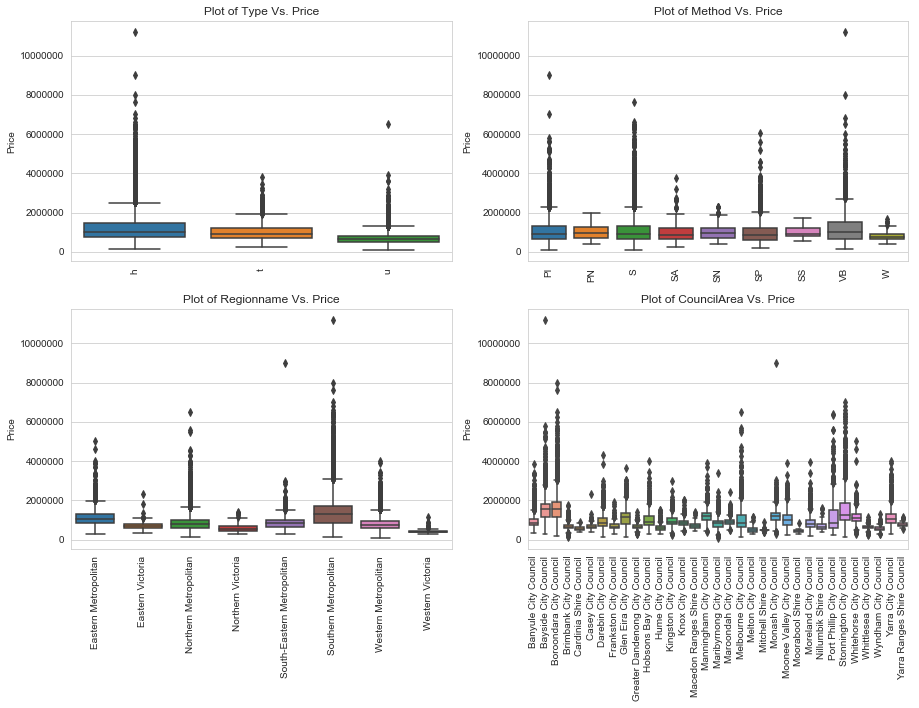

In [21]:
# plots vs price
sns.set_style("whitegrid")
plots_vs_price = imputed_df[['Type', 'Method', 'Regionname', 'CouncilArea']]

fig = plt.figure(1, figsize=(15,15))
numplt = 0
for x in plots_vs_price.columns:
    numplt += 1
    ax = fig.add_subplot(3, 2, numplt)
    sns.boxplot(x=plots_vs_price[x], y=imputed_df['Price'], ax=ax)
    plt.title('Plot of '+str(x)+' Vs. Price')
    plt.xlabel(None)
    plt.ticklabel_format(style='plain', axis='y')
    plt.xticks(rotation=90)
plt.show()

- The median price is the highest for houses, then townhouses, lastly, is apartments/duplexes, which is what we would expect.
- It doesn't appear to matter what method of sale is used as we can see the median price is fairly equal
- The Southern Metro area has the highest median price and also contains the max price in the dataset.
- The Bayside and Boroodara council areas are the two that have the highest median price for council areas.

In [22]:
#print(imputed_df[imputed_df.Regionname=='Southern Metropolitan'].groupby(['Suburb', 'CouncilArea'])['Price'].median().sort_values(ascending=False))

# Calculate percentage of homes per region that are above median 
regmeds = imputed_df.groupby('Regionname')['Price'].median()
regcounts = imputed_df.groupby('Regionname')['Price'].count()

abovemed = imputed_df[imputed_df.Price>=imputed_df.Price.median()]
#print(abovemed)

ab = abovemed.groupby('Regionname')['Price'].count()
#print(ab)

print('Percentage of homes by region above median value of $870,000:\n')
print(round((ab/regcounts).sort_values(ascending=False),2)*100)

Percentage of homes by region above median value of $870,000:

Regionname
Southern Metropolitan         71.0
Eastern Metropolitan          66.0
Northern Metropolitan         36.0
South-Eastern Metropolitan    35.0
Western Metropolitan          32.0
Eastern Victoria              12.0
Northern Victoria              9.0
Western Victoria               1.0
Name: Price, dtype: float64


We can see that in the Souther and Eastern Metropolitan areas over 50% of the homes are sold over the median value, where the other regions are well under 50%.

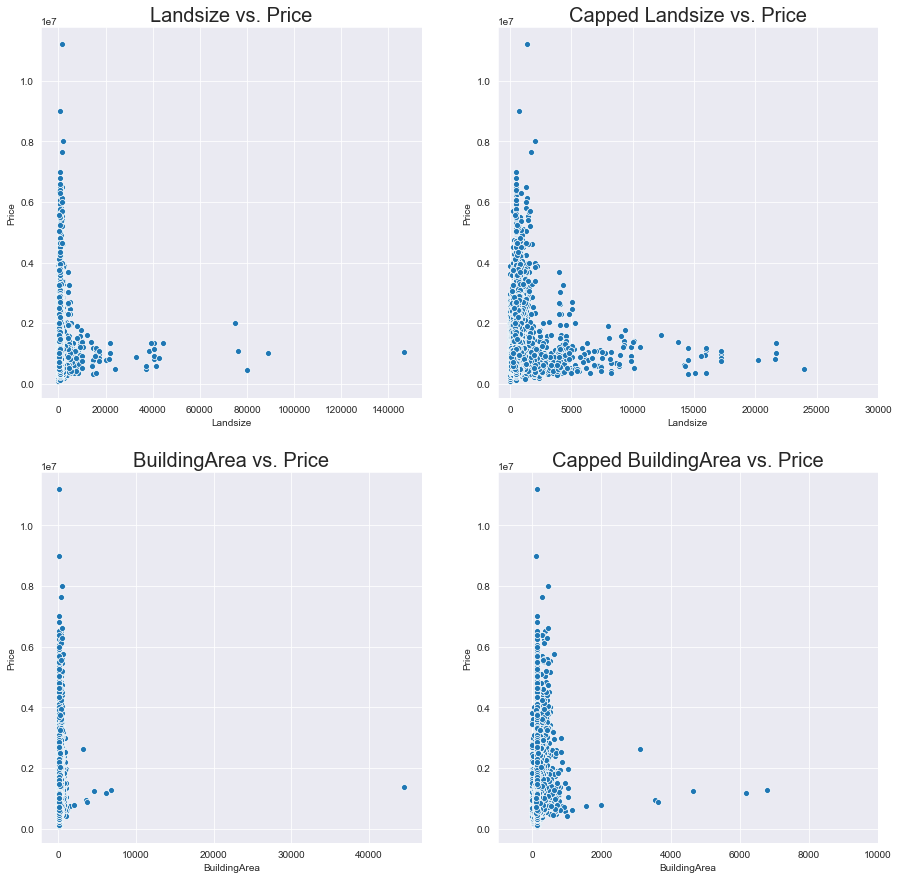

There are 2437 homes with a 0 landsize
There are 76 homes with a 0 building area


In [23]:
sns.set_style('darkgrid')
f, axes = plt.subplots(2,2, figsize = (15,15))

sns.scatterplot(x=imputed_df.Landsize, y=imputed_df.Price, ax=axes[0,0])
axes[0,0].set_title('Landsize vs. Price', fontsize=20)

sns.scatterplot(x=imputed_df.Landsize, y=imputed_df.Price, ax=axes[0,1])
axes[0,1].set_title('Capped Landsize vs. Price', fontsize=20)
axes[0,1].set_xlim(-1000,30000)

sns.scatterplot(x=imputed_df.BuildingArea, y=imputed_df.Price, ax=axes[1,0])
axes[1,0].set_title('BuildingArea vs. Price', fontsize=20)

sns.scatterplot(x=imputed_df.BuildingArea, y=imputed_df.Price, ax=axes[1,1])
axes[1,1].set_title('Capped BuildingArea vs. Price', fontsize=20)
axes[1,1].set_xlim(-1000,10000)
plt.show()

print('There are {} homes with a 0 landsize'.format(imputed_df[imputed_df.Landsize==0]['Landsize'].count()))
print('There are {} homes with a 0 building area'.format(imputed_df[imputed_df.BuildingArea==0]['BuildingArea'].count()))

I was expected a correlation between landsize / building area and price to be positive.

Let's continue to explore by looking at the date data vs price.

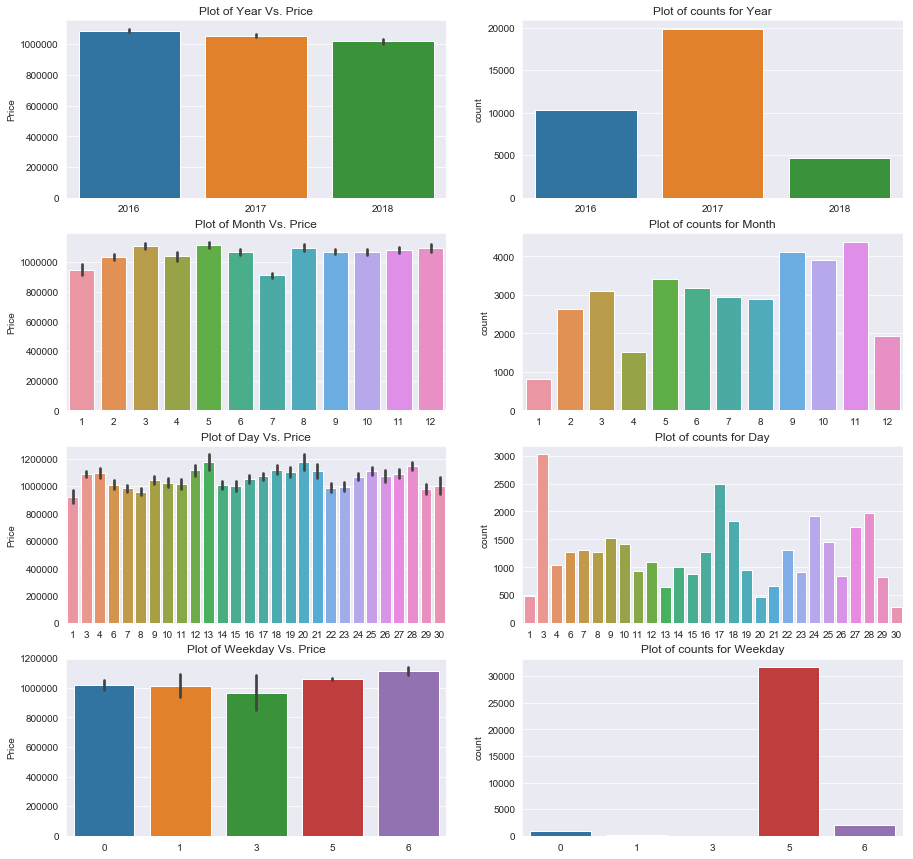

In [24]:
# date plots vs price
date_vs_price = imputed_df[['Year', 'Month', 'Day', 'Weekday']]

fig = plt.figure(1, figsize=(15,15))
numplt = 0
for x in date_vs_price.columns:
    numplt += 1
    ax = fig.add_subplot(4, 2, numplt)
    sns.barplot(x=date_vs_price[x], y=imputed_df['Price'], ax=ax)
    plt.title('Plot of '+str(x)+' Vs. Price')
    plt.xlabel(None)
    plt.ticklabel_format(style='plain', axis='y')
    
    numplt += 1
    ax = fig.add_subplot(4, 2, numplt)
    sns.countplot(x=date_vs_price[x], ax=ax)
    plt.title('Plot of counts for '+ str(x))
    plt.xlabel(None)
plt.show()

- The average price of homes sold in 2016 was higher than the other years, while the most homes were sold in 2017 by a factor of 2 compared to 2016.
- The price of homes by month is fairly consistant with the average price of $1.05 million, with July being the only month falling behind.
- The 3rd day of the month and the 17th stick out as the most common days for a sale. 
- The interesting thing to note with the weekday that a home is sold on is that almost all homes sold in this data set are sold on a Saturday.

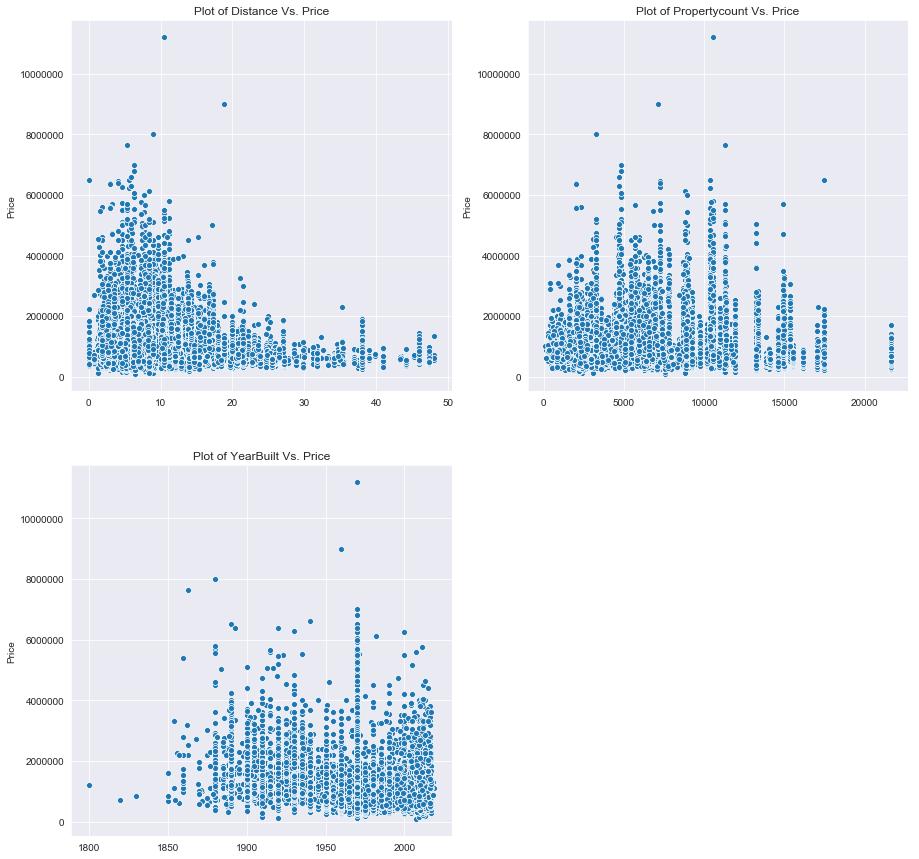

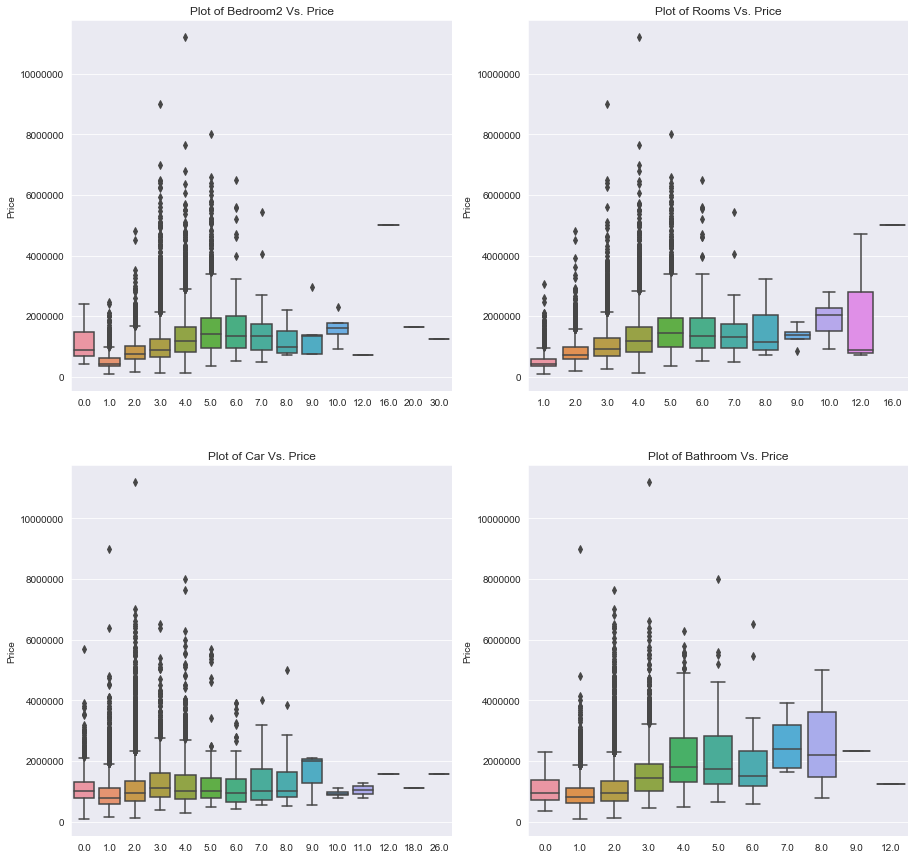

In [25]:
# numeric plots vs price
sns.set_style("darkgrid")
numplots_vs_price = imputed_df[['Distance', 'Propertycount', 'YearBuilt']]

fig = plt.figure(1, figsize=(15,15))
numplt = 0
for x in numplots_vs_price.columns:
    numplt += 1
    ax = fig.add_subplot(2, 2, numplt)
    sns.scatterplot(x=numplots_vs_price[x], y=imputed_df['Price'], ax=ax)
    plt.title('Plot of '+str(x)+' Vs. Price')
    plt.xlabel(None)
    plt.ticklabel_format(style='plain', axis='y')
    
plt.show()

# plots vs price
sns.set_style("darkgrid")
boxplots_vs_price = imputed_df[['Bedroom2', 'Rooms', 'Car', 'Bathroom']]

fig = plt.figure(1, figsize=(15,15))
numplt = 0
for x in boxplots_vs_price.columns:
    numplt += 1
    ax = fig.add_subplot(2, 2, numplt)
    sns.boxplot(x=boxplots_vs_price[x], y=imputed_df['Price'], ax=ax)
    plt.title('Plot of '+str(x)+' Vs. Price')
    plt.xlabel(None)
    plt.ticklabel_format(style='plain', axis='y')

plt.show()

- The closer to the Central Business District the higher the price
- Property count and year built don't have much impact on determining price
- The more rooms a home has the higher the price.
    - Rooms and bedrooms2 variables show the same information and rooms has less outliers like no 0 room homes and no homes with rooms above 16
- The number of car spots fluctuates slightly until it peaks at 9, but otherwise a weak positive relationship with price
- There is a clear increasing trend for the number of bathrooms and price.

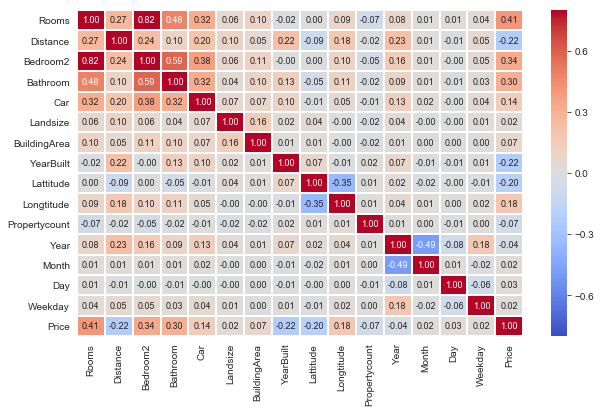

In [26]:
# correlation plot without the tracking columns
corrcols = imputed_df[['Suburb', 'Address', 'Type', 'Method', 'SellerG', 
                       'CouncilArea', 'Regionname', 'Rooms', 
                       'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 
                       'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 
                       'Lattitude', 'Longtitude', 'Propertycount', 
                       'Year', 'Month', 'Day', 'Weekday', 'Price']]

plt.figure(figsize=(10,6))
sns.heatmap(corrcols.corr(), cmap='coolwarm', vmin=-.8, vmax=0.8, linewidth=1, 
            annot=True, annot_kws={"size": 9}, fmt='0.2f')
plt.show()

The biggest issue with multicollinearity is between the Room and Bedroom2, which we saw earlier in the boxplots.  They are providing the same information and should be correlated because of that.  Moving forward we will drop bedroom2 because the rooms variable didn't have as many outliers to deal with.

There is some moderate correlation between rooms, car, bath as well.

**Negative correlation with Price**
- Distance: the closer to the CBD the higher the price
- Year Built: newer homes cost less than older homes
- Lattitude

**Positive correlation with Price**
- Rooms: more rooms means higher price
- Bathroom: more bathrooms, higher price
- Longitude
- Car: more cars, higher price

In [27]:
# drop bedroom2 from the data because of its high correlation with rooms a
drop_df.drop('Bedroom2', 1, inplace=True)
imputed_df.drop('Bedroom2', 1, inplace=True)

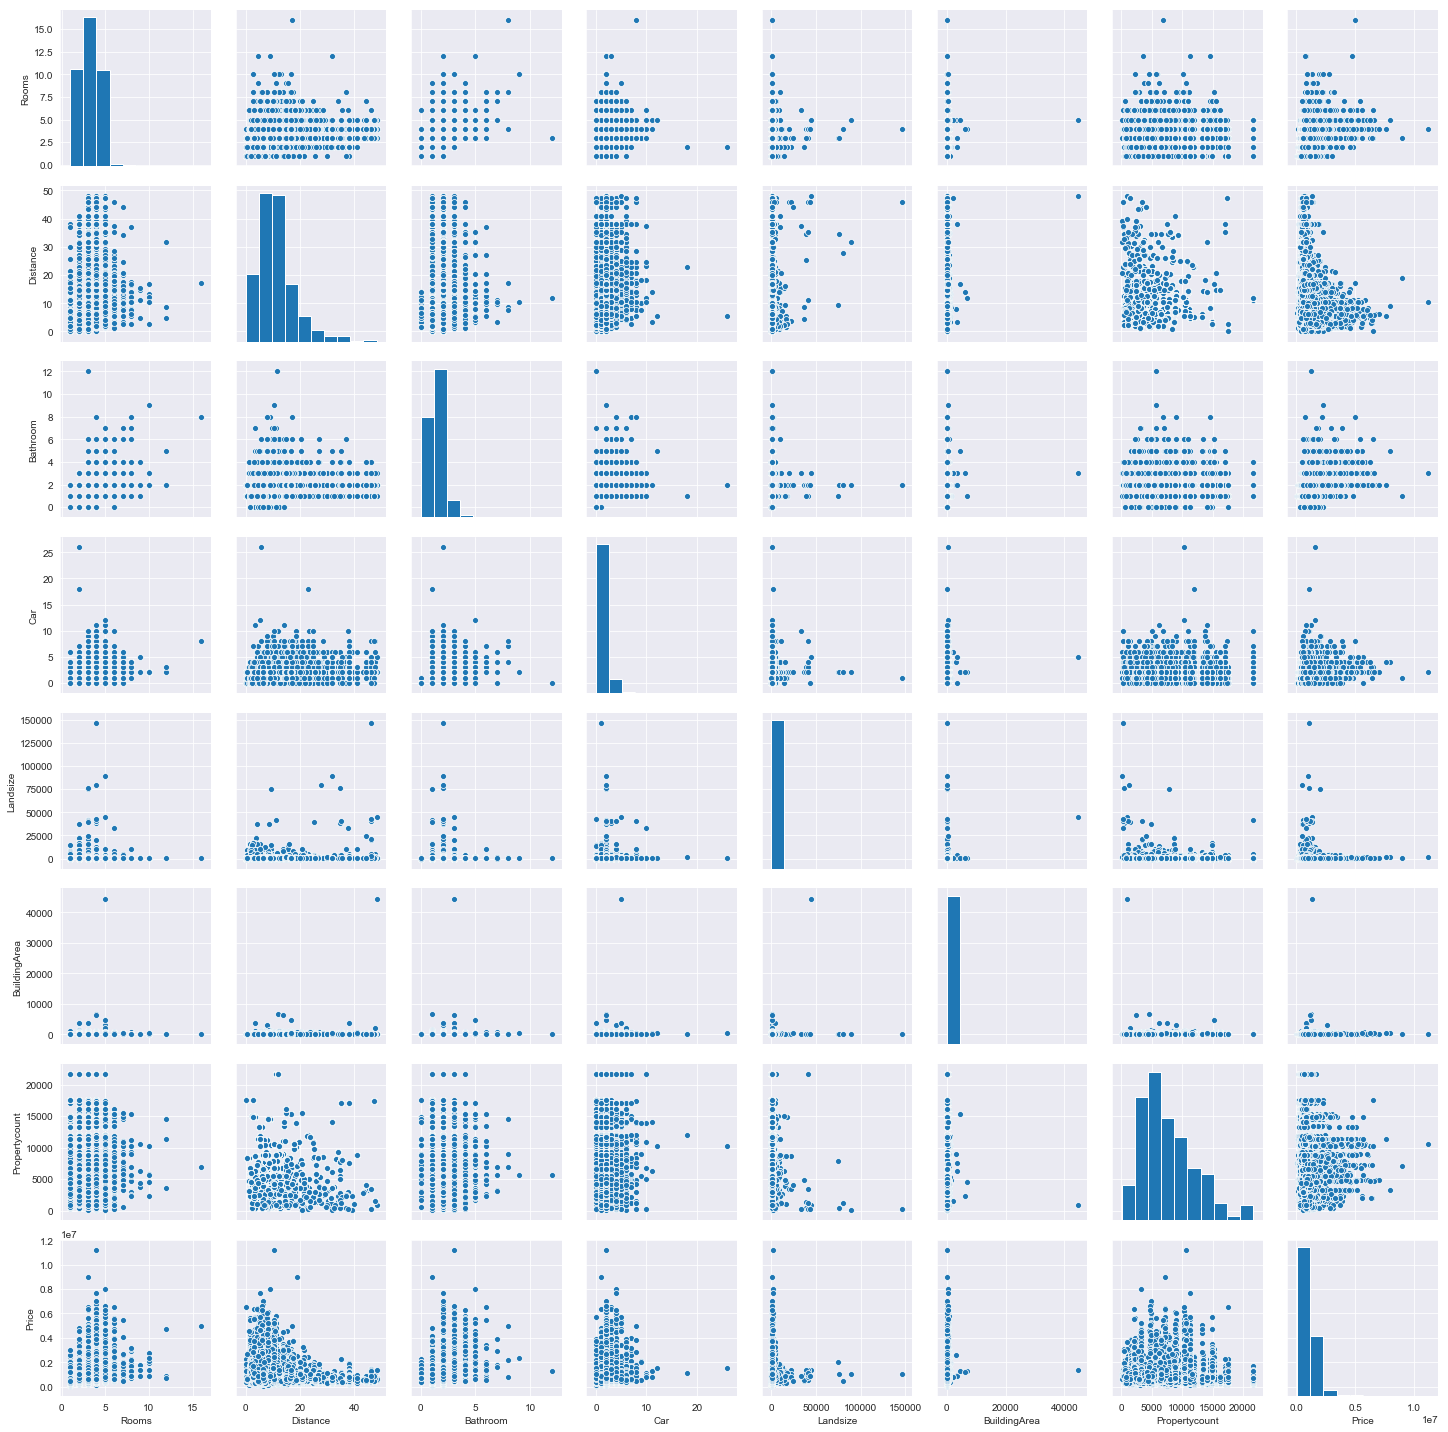

In [28]:
sns.pairplot(data = imputed_df, vars= ['Rooms', 'Distance', 
                            'Bathroom', 'Car', 'Landsize',
                            'BuildingArea',  'Propertycount','Price'], palette = 'viridis')
plt.show()

## Build some models

With this regression model we will want to look at how well the model fits the data (R-squared) because that will tell us how much of the dependent variable variance we have covered with the model.  We will also look at the Mean Square Error, Root Mean Square Error, and the Mean Absolute Error.  The MSE is the average squared difference between the estimated values (predicted) and what is estimated (actual).  The RMSE is the square root of the MSE, thus the units for RMSE are the same as the dependent variable.  The MAE is the average absolute difference between the predicted and the actual value.  All three of these metrics are loss functions, so we will be looking to minimize them.

In [85]:
def run_model(clf, x, y, cv=False, res=False, test=False, xt=None, yt=None):
    '''Model data with options for plotting residuals and '''
    
    # Start time
    t0 = time.time()
    
    # Fit model on training data
    fitted = clf.fit(x,y)
    
    # Score model
    score = clf.score(x,y)
    print('Model Score: {}'.format(score))
    print('-'*50)
    
    # Predict X
    pred = clf.predict(x)
    
    # Residuals
    residual = y-pred
    
    # Mean Square Error, Root Mean Square Error, Mean Absolute Error
    mse = mean_squared_error(y,pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y,pred)
    print('Mean Square Error: {0:0.05f}'.format(mse))
    print('Root Mean Square Error: ${0:,.2f}'.format(rmse))
    print('Mean Absolute Error: {0:0.05f}'.format(mae))
    print('-'*50)
    
    # Cross validation
    if cv==True:
        crossval = cross_val_score(clf, x, y, cv=5)
        print(crossval)
        print('-'*50)     

    if test==True:
        # Score test
        score_test= clf.score(xt,yt)
        print('Test Score: {}'.format(score_test))
        
    # Residual plots
    if res==True:
        sns.distplot(residual)
        plt.title('Residual counts')
        plt.xlabel('Residual')
        plt.show()
        
        sns.scatterplot(pred, residual)
        plt.xlabel('Predicted')
        plt.ylabel('Residual')
        plt.axhline(y=0)
        plt.title('Residual vs. Predicted')
        plt.show()
    
   
    
    # End time
    t1=time.time()
    print('Total Time: {}'.format(t1-t0))
    
    return fitted

In [46]:
# create dummy variables for the categorical variables
X = pd.get_dummies(imputed_df.drop('Price', 1))
Y = imputed_df.Price
print(X.shape)

(34857, 35034)


In [74]:
# split data
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.3, random_state=42)
print(xtrain.shape)

(24399, 35034)


Model Score: 0.6463326074371197
--------------------------------------------------
Mean Square Error: 123689870576.85716
Root Mean Square Error: $351,695.71
Mean Absolute Error: 236618.79357
--------------------------------------------------
[0.53553115 0.49384665 0.49719414 0.49885309 0.48416498]


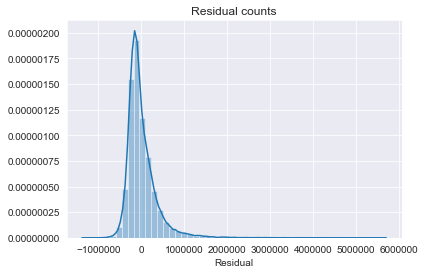

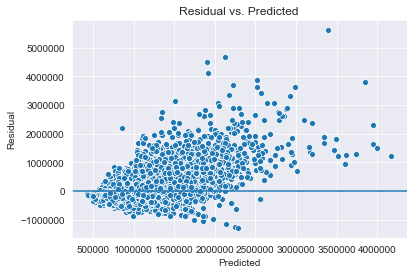

Total Time: 125.99033236503601


In [75]:
# Random Forest Regressor
rfr = run_model(RandomForestRegressor(max_features='sqrt', max_depth=50, random_state=42), xtrain, ytrain, cv=True, res=True)

With the Random Forest Regression we were able to capture about 65% of the model variance, but that was overfitting as seen by the cross validation scoring, which was around 50%.  The RMSE tells us how off our predicted values are, on average, from the actual values.  The RFR tells us that our predicted values are, on average, off by $351,695.71 from the actual value.

The Residuals are normally distributed with a slight right skewness and fairly homoscedastic but could be improved.

Model Score: 0.5268166956212204
--------------------------------------------------
Mean Square Error: 167037735570.33746
Root Mean Square Error: $408,702.50
Mean Absolute Error: 250053.99592
--------------------------------------------------
[0.41926659 0.40696745 0.39051644 0.40458526 0.40522432]


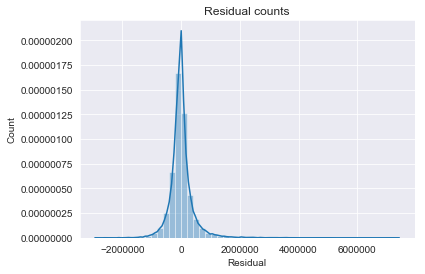

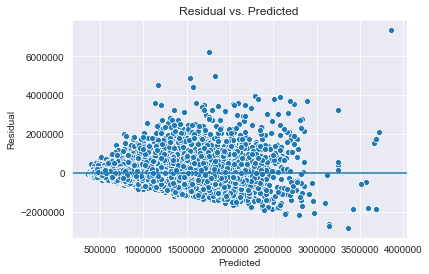

Total Time: 2218.096560239792


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

In [41]:
# KNN Regressor
#run_model(KNeighborsRegressor(n_neighbors=10), xtrain, ytrain, cv=True, res=True)

# dont run this again!

The KNN Regression model scored worse than the Random Forest Regression by only covering about 52% of the dependent variable variance.  The RMSE was also larger implying that our predicted values are off by $408,702.50, on average, when compared to the actual.

The data has way to many features still being included - let's try to pick out the most important features using the Random Forest feature importance method.

In [76]:
# Get the top features
topfeats = pd.DataFrame(list(zip(xtrain.columns, rfr.feature_importances_)),
                        columns=['feature', 'importance']).sort_values(by='importance', ascending=False).reset_index(drop=True)
print(topfeats)

zeroes = topfeats[topfeats.importance==0]
print(zeroes.shape)

                                    feature  importance
0                                     Rooms    0.065546
1          Regionname_Southern Metropolitan    0.053723
2                                    Type_h    0.040492
3                          SellerG_Marshall    0.034864
4                              BuildingArea    0.028899
5                                  Bathroom    0.028793
6                                 YearBuilt    0.025200
7                                Longtitude    0.025026
8                                  Landsize    0.023930
9                                  Distance    0.023452
10                                Lattitude    0.022635
11                                   Type_u    0.020763
12                          Postcode_3126.0    0.013773
13                                      Car    0.013440
14                                    Month    0.013329
15     CouncilArea_Stonnington City Council    0.013213
16         Regionname_Northern Metropolitan    0

We can clearly see that there are a number of features that offer no value, specifically 25,433 features are useless.  Let's drop those and run the models again.

In [80]:
# keep only top features
features_to_drop = zeroes.feature.tolist()
features = X.drop(features_to_drop, 1)
print(features.shape)

(34857, 9601)


In [81]:
# split the data again
xtrainf, xtestf, ytrainf, ytestf = train_test_split(features, Y, test_size=0.3, random_state=42)

Model Score: 0.8487665849814774
--------------------------------------------------
Mean Square Error: 52891620556.20196
Root Mean Square Error: $229,981.78
Mean Absolute Error: 147479.98041
--------------------------------------------------
[0.58381539 0.59736935 0.60933771 0.5629833  0.56312088]


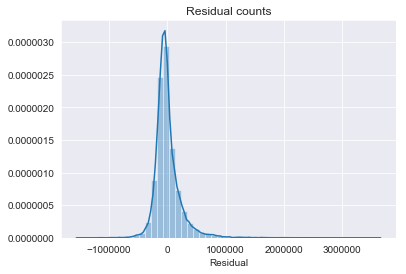

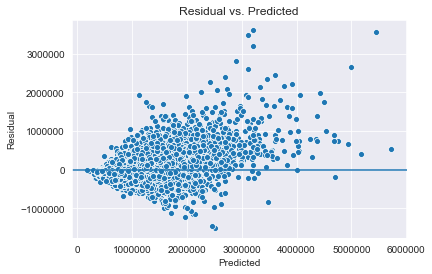

Total Time: 55.55226373672485


In [84]:
# Random Forest Regressor with top features
rfr = run_model(RandomForestRegressor(max_features='sqrt', max_depth=50, random_state=42), xtrainf, ytrainf, cv=True, res=True)

We have improved the RMSE by using only the features that had some relevent importance but we are still overfitting with the Random Forest model, as is evidenced by the cross validation being around 57%.  Some parameter tuning would likely fix this issue.  The residual normality is still good and the residual values have tightened up some.

This time let's only select the top 50 features to keep in our dataset.

In [61]:
# check top features again
newtopfeats = pd.DataFrame(list(zip(xtrainf.columns, rfr.feature_importances_)),
                        columns=['feature', 'importance']).sort_values(by='importance', ascending=False).reset_index(drop=True)
print(newtopfeats)
feats_to_keep = newtopfeats.feature[:50]
finalfeats = features[feats_to_keep]
print(finalfeats.shape)

                                   feature  importance
0                                    Rooms    0.061225
1                                   Type_u    0.051743
2                                 Distance    0.047288
3                                Lattitude    0.046913
4                               Longtitude    0.043664
5                                 Landsize    0.037843
6         Regionname_Southern Metropolitan    0.034626
7                                   Type_h    0.033353
8                             BuildingArea    0.032416
9                                YearBuilt    0.030278
10                                Bathroom    0.028042
11                                     Day    0.022777
12                                   Month    0.020215
13                                     Car    0.016780
14     CouncilArea_Boroondara City Council    0.015445
15                           Propertycount    0.013867
16                        SellerG_Marshall    0.011648
17        

In [86]:
# split the data again
xtrainf1, xtestf1, ytrainf1, ytestf1 = train_test_split(finalfeats, Y, test_size=0.3, random_state=42)

Model Score: 0.6713853772845129
--------------------------------------------------
Mean Square Error: 114928039757.33965
Root Mean Square Error: $339,010.38
Mean Absolute Error: 214136.18530
--------------------------------------------------
[0.60996919 0.61645535 0.60210501 0.58550433 0.58277449]
--------------------------------------------------
Test Score: 0.570880693363772


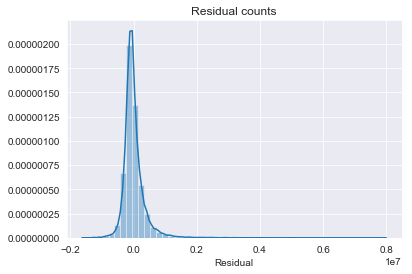

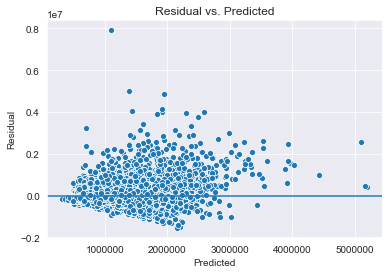

Total Time: 1.4339005947113037


In [90]:
# Random Forest Regressor with top 50 features
rfr = run_model(RandomForestRegressor(max_features='sqrt', max_depth=10, random_state=42), 
                xtrainf1, ytrainf1, cv=True, res=True, test=True, xt=xtestf1, yt=ytestf1)

Model Score: 0.5260769277634547
--------------------------------------------------
Mean Square Error: 165747492420.86990
Root Mean Square Error: $407,120.98
Mean Absolute Error: 250063.56004
--------------------------------------------------
[0.4102554  0.42465145 0.43684121 0.38322814 0.3683465 ]
--------------------------------------------------


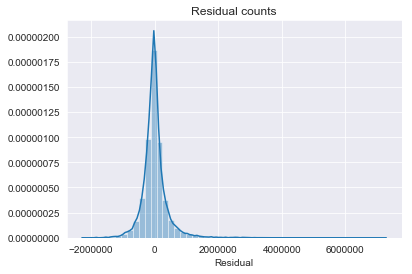

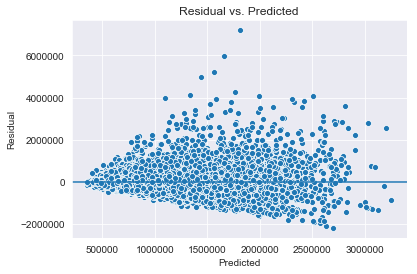

Total Time: 4.033754825592041


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

In [88]:
# KNN Regression on top features
run_model(KNeighborsRegressor(n_neighbors=10), xtrainf1, ytrainf1, cv=True, res=True)

Model Score: -0.06668490054827281
--------------------------------------------------
Mean Square Error: 373057058890.84949
Root Mean Square Error: $610,783.97
Mean Absolute Error: 407035.39021
--------------------------------------------------
[-0.07838866 -0.05879613 -0.06416779 -0.05781184 -0.0723857 ]
--------------------------------------------------


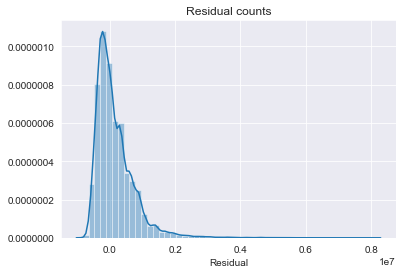

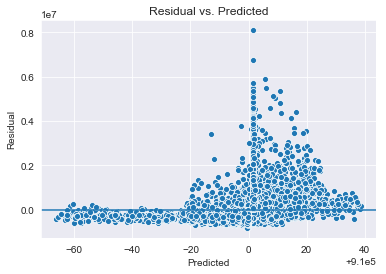

Total Time: 457.57390666007996


SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [91]:
# Support Vector Machine regression
run_model(SVR(C=1), xtrainf1, ytrainf1, cv=True, res=True)

The Random Forest Model has worked consistently better than the KNN model.  The RFR still needs some parameter tuning to fix the overfitting, but bringing down the features to 50 has still allowed for us to capture about 58% of the dependent variable variance, as seen with the cross validation.  The Support vector regression was no good and we will not continue to use this.  

Next step is to introduce our linear regression model.  For the linear regression I will start out with the top 50 features found from the random forest model.  We will definitely want to bring that number of features down and keep only the strongest features for determining housing price.  The goal is to try and beat the Random Forest Model which is currently the best model with an RMSE of around 330,000 and an score on the test set of 57% and cross validation of around 60%.

### Linear Regression

Model Score: 0.568184647885166
--------------------------------------------------
Mean Square Error: 151020948324.17322
Root Mean Square Error: $388,614.14
Mean Absolute Error: 251464.45301
--------------------------------------------------
[0.58177881 0.56451098 0.58684269 0.54114182 0.54515237]
--------------------------------------------------
Test Score: 0.5135438666614969


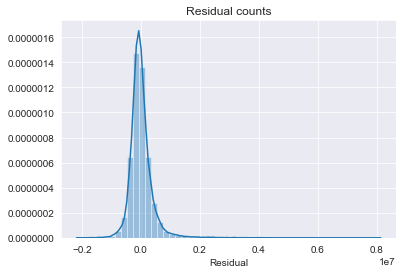

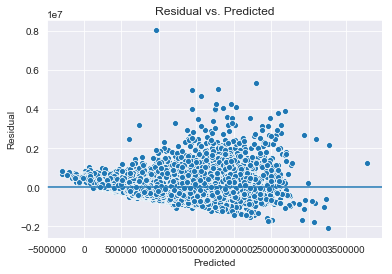

Total Time: 0.8545753955841064


In [104]:
lr = run_model(LinearRegression(), xtrainf1, ytrainf1, cv=True, res=True, test=True, xt=xtestf1, yt=ytestf1)

In [101]:
display(pd.DataFrame(lr.coef_, index=xtrainf1.columns, 
                     columns=['Coefficient']).sort_values(by='Coefficient', ascending=False))
print('Intercept: {}'.format(lr.intercept_))

,Coefficient
Suburb_Malvern,490617.723933
Postcode_3206.0,469035.812144
Postcode_3186.0,408005.427514
Suburb_Canterbury,358904.713649
Postcode_3126.0,358904.713649
Postcode_3103.0,350761.680774
SellerG_Abercromby's,300823.112179
CouncilArea_Bayside City Council,293510.208623
Suburb_Balwyn North,219143.239186
SellerG_Marshall,201923.323524


Intercept: -88297500.82360783


We scored slightly lower in the test set than the Random Forest model with a 51%.  The residuals are very comparable to the random forest model as well.

We have a some very high coefficients and a very large (negative) intercept.  Let's try using the Lasso Regression to further reduce our number of features.

Model Score: 0.5628739071660048
--------------------------------------------------
Mean Square Error: 152878300305.25391
Root Mean Square Error: $390,996.55
Mean Absolute Error: 252377.44276
--------------------------------------------------
[0.57263136 0.5610817  0.58227969 0.5400576  0.53689236]
--------------------------------------------------
Test Score: 0.5012948871674588


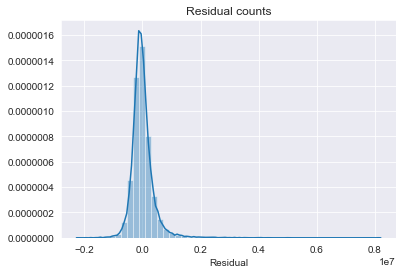

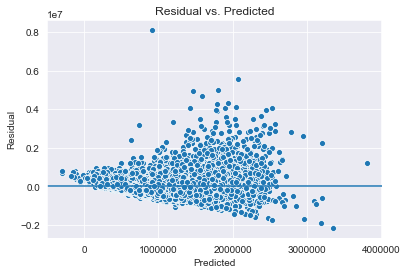

Total Time: 1.8251147270202637


In [116]:
las = run_model(Lasso(alpha=1e3), xtrainf1, ytrainf1, cv=True, res=True, test=True, xt=xtestf1, yt=ytestf1)

In [117]:
display(pd.DataFrame(las.coef_, index=xtrainf1.columns, 
                     columns=['Coefficient']).sort_values(by='Coefficient', ascending=False))
print('Intercept: {}'.format(las.intercept_))

,Coefficient
Postcode_3126.0,370216.825434
Postcode_3186.0,335023.628624
Suburb_Malvern,333222.665561
Postcode_3206.0,285973.347663
CouncilArea_Bayside City Council,275748.194871
SellerG_Marshall,198738.892544
CouncilArea_Boroondara City Council,190602.872608
Type_h,173674.440233
Postcode_3103.0,168637.297825
Rooms,149233.518539


Intercept: -62256016.409195706


With the lasso regression we were able to get the features down to 41.  Let's see what we can get out of looking at a summary of the linear regression from statsmodels.

In [151]:
# add a constant for the intercept
xtrainf1stats = sm.add_constant(xtrainf1)
xtestf1stats = sm.add_constant(xtestf1)

# fit model and check summary
statsmod = sm.OLS(ytrainf1, xtrainf1stats)
results = statsmod.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     681.7
Date:                Wed, 07 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:21:45   Log-Likelihood:            -3.4864e+05
No. Observations:               24399   AIC:                         6.974e+05
Df Residuals:                   24351   BIC:                         6.978e+05
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [152]:
pvals = results.pvalues.sort_values(ascending=False)
print(pvals)

TrackerLandsize                         8.836356e-01
Regionname_Southern Metropolitan        8.685524e-01
TrackerBuildingArea                     5.983038e-01
Weekday                                 4.581224e-01
Postcode_3144.0                         2.357358e-01
Method_SP                               1.652363e-01
Regionname_Eastern Metropolitan         2.345261e-02
Postcode_3073.0                         1.968491e-02
Day                                     1.636290e-02
Method_PI                               5.166061e-03
SellerG_hockingstuart                   2.070124e-03
Propertycount                           1.376835e-03
TrackerYearBuilt                        1.273066e-03
Month                                   1.335614e-04
Method_VB                               5.442585e-05
SellerG_Abercromby's                    2.545237e-05
Suburb_Malvern                          1.409302e-05
Postcode_3101.0                         1.392379e-05
Longtitude                              2.8060

At an alpha value of 0.05 we have 6 features that are not significant.  At this point we can filter off the insignificant features using a wrapper method - with backward passes until the remaining features are all significant and the model fit doesn't drop too much.

Let's just see what happens if we use some of the top features according to significance.

In [156]:
def statreg(n):
    
    top = pvals.index[-n:]
    topstats = sm.add_constant(xtrainf1stats[top])

    statsmod1 = sm.OLS(ytrainf1, topstats)
    results = statsmod1.fit()
    print(results.summary())
    return

In [157]:
# Top 25
statreg(25)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     1437.
Date:                Wed, 07 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:23:49   Log-Likelihood:            -3.4906e+05
No. Observations:               24399   AIC:                         6.982e+05
Df Residuals:                   24377   BIC:                         6.983e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Ty

In [160]:
# Top 15
statreg(15)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     1712.
Date:                Wed, 07 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:26:15   Log-Likelihood:            -3.5054e+05
No. Observations:               24399   AIC:                         7.011e+05
Df Residuals:                   24384   BIC:                         7.012e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [161]:
# Top 5
statreg(5)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     2994.
Date:                Wed, 07 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:26:36   Log-Likelihood:            -3.5305e+05
No. Observations:               24399   AIC:                         7.061e+05
Df Residuals:                   24393   BIC:                         7.062e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   